# Results Analysis

Script to analyse the results of the calibration process.

In [1]:
import pandas as pd
import math
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

In [2]:
yearOfInterest = '2017'

hourlyOrMonthly = 'Hourly'

outputOfInterest = 'Electricity'
#outputOfInterest = 'DistrictHeating'
#outputOfInterest = 'Water'

In [3]:
if outputOfInterest == 'Water':
    unit = 'm3'
    
else:
    unit = 'J'

columnOfInterest = f'{outputOfInterest}:Facility [{unit}]({hourlyOrMonthly})'

In [4]:
initialSimulated = f'..\Data\InitialSimulatedData\\{hourlyOrMonthly}_BuildingInitialSimulation{yearOfInterest}.csv'
measured = f'..\Data\PreprocessedMeasuredData\Building{yearOfInterest}_{outputOfInterest}_AutotuneData_{hourlyOrMonthly}.csv'
simulated = f'..\Data\SimulatedData\Building{yearOfInterest}_{outputOfInterest}_{hourlyOrMonthly}.csv'

In [5]:
initialSimulated_df = pd.read_csv(initialSimulated)
measured_df = pd.read_csv(measured)
simulated_df = pd.read_csv(simulated)

In [6]:
initialSimulated_df = initialSimulated_df[['Date/Time', columnOfInterest]]
initialSimulated_df.columns = ['Date/Time', f'initialSimulated_{columnOfInterest}']

measured_df = measured_df[['Date/Time', columnOfInterest]]
measured_df.columns = ['Date/Time', f'measured_{columnOfInterest}']

simulated_df = simulated_df[['Date/Time', columnOfInterest]]
simulated_df.columns = ['Date/Time', f'simulated_{columnOfInterest}']

In [7]:
merged_df1 = measured_df.merge(initialSimulated_df, on='Date/Time')
merged_df2 = merged_df1.merge(simulated_df, on='Date/Time')

In [8]:
def getCVRMSE(data):
    df = data.copy()
    
    df['m-is'] = (df[f'measured_{columnOfInterest}'] - df[f'initialSimulated_{columnOfInterest}'])**2
    df['m-s'] = (df[f'measured_{columnOfInterest}'] - df[f'simulated_{columnOfInterest}'])**2
    
    mis_val = df['m-is'].sum()
    ms_val = df['m-s'].sum()
    
    numDataPoints = len(df)
    measuredAverage = df[f'measured_{columnOfInterest}'].mean()
    
    initial_CVRMSE = (math.sqrt(mis_val/numDataPoints)/measuredAverage)*100
    improved_CVRMSE = (math.sqrt(ms_val/numDataPoints)/measuredAverage)*100
    
    return initial_CVRMSE, improved_CVRMSE

In [9]:
def getMBE(data):
    df = data.copy()
    
    df['m-is'] = (df[f'measured_{columnOfInterest}'] - df[f'initialSimulated_{columnOfInterest}'])
    df['m-s'] = (df[f'measured_{columnOfInterest}'] - df[f'simulated_{columnOfInterest}'])
    
    mis_val = df['m-is'].sum()
    ms_val = df['m-s'].sum()
    
    measuredSum = df[f'measured_{columnOfInterest}'].sum()
    
    initial_MBE = (mis_val/measuredSum)*100
    improved_MBE = (ms_val/measuredSum)*100
    
    return initial_MBE, improved_MBE

In [10]:
initial_CVRMSE, improved_CVRMSE = getCVRMSE(merged_df2)

In [11]:
print(f'Initially the CVRMSE is {initial_CVRMSE}%')
print('\n')
print(f'After calibration the CVRMSE is {improved_CVRMSE}%')
print('\n')
print(f'An improvement of {initial_CVRMSE - improved_CVRMSE}% was seen')

Initially the CVRMSE is 84.1438998878813%


After calibration the CVRMSE is 79.0523140214075%


An improvement of 5.091585866473807% was seen


In [12]:
initial_MBE, improved_MBE = getMBE(merged_df2)

In [13]:
print(f'Initially the MBE is {initial_MBE}%')
print('\n')
print(f'After calibration the MBE is {improved_MBE}%')
print('\n')
print(f'An improvement of {initial_MBE - improved_MBE}% was seen')

Initially the MBE is 7.745286010081356%


After calibration the MBE is 13.46143209867359%


An improvement of -5.716146088592234% was seen


In [14]:
df = pd.read_csv(f'..\SensitivityAnalysis\IC_DataFrames\\{outputOfInterest}_IC_DataFrame.csv')
df['Final'] = 0
df['Max'] = 0
df['Min'] = 0

In [15]:
df1 = pd.read_csv(f'..\IDF_Files\Calibrated_{outputOfInterest}\Building2017_{outputOfInterest}_{hourlyOrMonthly}_inds.csv', header=None)

In [16]:
df2 = pd.read_csv(f'..\SensitivityAnalysis\Building_{outputOfInterest}_AutotuneParameters.csv')

In [17]:
df2['COF'] = df2['Class'] + '-->' + df2['Object'] + '-->' + df2['Field']

In [18]:
cofList = list(df2['COF'])

In [19]:
cofList.insert(0, 'C')
cofList.insert(0, 'B')
cofList.insert(0, 'A')

In [20]:
df1.columns = cofList

In [21]:
def removeOpenBracket(row, cofList=cofList):
    return row[cofList[3]].split('[')[1]

def removeCloseBracket(row):
    return row[cofList[-1]].split(']')[0]

In [22]:
df1[cofList[3]] = df1.apply(lambda row: removeOpenBracket(row), axis=1)
df1[cofList[-1]] = df1.apply(lambda row: removeCloseBracket(row), axis=1)

In [23]:
df3 = df1.loc[df1['B'] == 0]

In [24]:
theSomething = df3.iloc[-1]

In [25]:
theSomething = theSomething.iloc[3:]

In [26]:
def doTheThing(row, theSomething=theSomething):
    return theSomething[row['COF']]

In [27]:
df['Final'] = df.apply(lambda row: doTheThing(row), axis=1)

In [28]:
df['Final'] = df['Final'].astype(float)

In [29]:
with open('..\SensitivityAnalysis\Building_JSON_Jobs.json') as f:
    data = json.load(f)
        
    f.close()

In [30]:
def minApply(row, data=data):
    return data[row['COF']]['Min']

def maxApply(row, data=data):
    return data[row['COF']]['Max']

In [31]:
df['Min'] = df.apply(lambda row: minApply(row), axis=1)
df['Max'] = df.apply(lambda row: maxApply(row), axis=1)

In [32]:
df['relVal'] = 1 - ((df['Max'] - df['Final'])/(df['Max'] - df['Min']))

In [33]:
df = df.reset_index()

In [34]:
def fixValues(row):
    
    if row['relVal'] <= 1 and row['relVal'] >= 0:
        return row['relVal']
    
    if float(row['relVal']) > 1:
        val = row['relVal']
        print(f'Greater than 1. Difference of {val - 1}')
        return 1
    
    if row['relVal'] < 0:
        val = row['relVal']
        print(f'Less than 0. Difference of {0 - val}')
        return 0

In [35]:
high = 0.1
medium = 0.25

In [36]:
fullLength = len(df)

In [37]:
high1df = df.loc[df['relVal'] >= (1-high)]
high0df = df.loc[df['relVal'] <= high]

high10 = len(high1df) + len(high0df)
high1 = len(high1df)
high0 = len(high0df)

high10Percent = (high10/fullLength)*100
high1Percent = (high1/fullLength)*100
high0Percent = (high0/fullLength)*100

In [38]:
medium1df = df.loc[(df['relVal'] >= (1-medium)) & (df['relVal'] < (1-high))]
medium0df = df.loc[(df['relVal'] <= medium) & (df['relVal'] > high)]

medium10 = len(medium1df) + len(medium0df)
medium1 = len(medium1df)
medium0 = len(medium0df)

medium10Percent = (medium10/fullLength)*100
medium1Percent = (medium1/fullLength)*100
medium0Percent = (medium0/fullLength)*100

In [39]:
lowdf = df.loc[(df['relVal'] < (1 - medium)) & (df['relVal'] > medium)]

low = len(lowdf)

lowPercent = (low/fullLength)*100

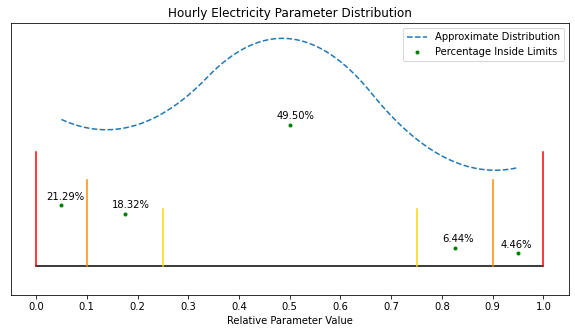

In [40]:
xData = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
x = [0.05, 0.175, 0.5, 0.825, 0.95]
y = [(high0Percent/100)+0.3, (medium0Percent/100)+0.3, (lowPercent/100)+0.3, (medium1Percent/100)+0.3, (high1Percent/100)+0.3]

f = interp1d(x, y, kind='quadratic')
x_new = np.linspace(0.05, 0.95, 500)
y_smooth=f(x_new)

plt.figure(figsize=(10,5))

ax1 = plt.axes()
ax1.axes.get_yaxis().set_visible(False)
plt.plot([0, 1], [0, 0], color='black')
plt.plot([0, 0], [0, 0.4], color='red')
plt.plot([1, 1], [0, 0.4], color='red')
plt.plot([0.1, 0.1], [0, 0.3], color='darkorange')
plt.plot([0.25, 0.25], [0, 0.2], color='gold')
plt.plot([0.9, 0.9], [0, 0.3], color='darkorange')
plt.plot([0.75, 0.75], [0, 0.2], color='gold')

plt.scatter(0.95, high1Percent/100, marker='.', color='green', label='Percentage Inside Limits')
plt.scatter(0.05, high0Percent/100, marker='.', color='green')
plt.scatter(0.825, medium1Percent/100, marker='.', color='green')
plt.scatter(0.175, medium0Percent/100, marker='.', color='green')
plt.scatter(0.5, lowPercent/100, marker='.', color='green')

plt.annotate('{:.2f}%'.format(high1Percent), (0.95, high1Percent/100), xytext=( 0.915,( (high1Percent/100) + 0.02)  ))
plt.annotate('{:.2f}%'.format(high0Percent), (0.05, high0Percent/100), xytext=( 0.02,( (high0Percent/100) + 0.02)  ))

plt.annotate('{:.2f}%'.format(medium1Percent), (0.825, medium1Percent/100), xytext=( 0.8,( (medium1Percent/100) + 0.02)  ))
plt.annotate('{:.2f}%'.format(medium0Percent), (0.175, medium0Percent/100), xytext=( 0.15,( (medium0Percent/100) + 0.02)  ))

plt.annotate('{:.2f}%'.format(lowPercent), (0.5, lowPercent/100), xytext=( 0.475,( (lowPercent/100) + 0.02)  ))

plt.plot (x_new,y_smooth, '--', label='Approximate Distribution')

ax1.set_ylim([-0.1, 0.85])
ax1.xaxis.set_ticks(xData)
plt.title(f'{hourlyOrMonthly} {outputOfInterest} Parameter Distribution')
plt.xlabel('Relative Parameter Value')
plt.legend()
plt.show()